# **CIS 520: Machine Learning**

## **Neural Networks**


- **Content Creators:** Yide Zhao, Mihir Parmar
- **Content Reviewers:**  Shaozhe Lyu, Michael Zhou, Tejas Srivastava, Jasleen Dhanoa
- **Objectives:**
  - How to build a neural net in pytorch
  - Understand different activation functions
  - How to compute the number of weights in a neural net
  - Understand different optimization methods
- **Acknowledge:**
  1. NeuromatchAcademy: https://github.com/NeuromatchAcademy/course-content/tree/master/tutorials/W3D4_DeepLearning1
  2. https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627



In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
import matplotlib as mpl
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torchsummary import summary

## **Autograding and the PennGrader**


Enter your PennID (numbers not letters!) in the specified section.

### Imports and Setup (Do Not Modify This Section)

In [2]:
%%capture
!pip install penngrader


In [3]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *

import dill
import base64

In [4]:
# For autograder only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")
    sys.exit()

[INFO, OK] Google Colab.


### Insert PennID here!

In [5]:
#PLEASE ENSURE YOUR PENN-ID IS ENTERED CORRECTLY. IF NOT, THE AUTOGRADER WON'T KNOW WHO 
#TO ASSIGN POINTS TO YOU IN OUR BACKEND
STUDENT_ID = 57931095 # YOUR PENN-ID GOES HERE AS AN INTEGER#

In [6]:
import penngrader.grader

grader = penngrader.grader.PennGrader(homework_id = 'CIS_5200_202230_HW_Neural_Networks_WS', student_id = STUDENT_ID)

PennGrader initialized with Student ID: 57931095

Make sure this correct or we will not be able to store your grade


In [7]:
# A helper function for grading utils
def grader_serialize(obj):        # A helper function
    '''Dill serializes Python object into a UTF-8 string'''
    byte_serialized = dill.dumps(obj, recurse = True)
    return base64.b64encode(byte_serialized).decode("utf-8")

## **Data Preparation**

In [8]:
trainset = datasets.MNIST('./data', download=True, train=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = datasets.MNIST('./data', download=True, train=False, transform=transforms.Compose([transforms.ToTensor()]))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Here, you can change the batch size from 16 to whatever number you like. You could try to change this number later once you learn how to train the network. Try to see how different batch size might influence the rate of convergence and accuracy.

**We are using Batch-Size as 16 for the autograder**

In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

The label is:  tensor(8)
The label is:  tensor(7)
The label is:  tensor(1)


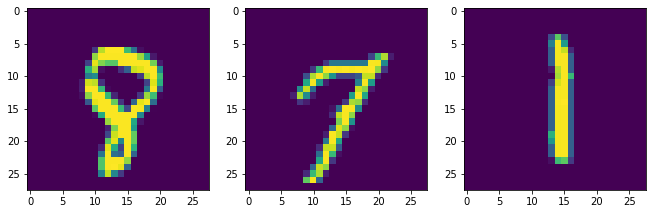

In [10]:
images, labels = iter(trainloader).next()
fig=plt.figure(figsize=(15, 10))
for i in range(1, 4):
    fig.add_subplot(1, 4, i)
    plt.imshow(images[i].numpy().squeeze())
    print('The label is: ', labels[i])
plt.show()

In [11]:
# print the shape of the label
print(labels.shape)

torch.Size([16])


In [12]:
images.shape

torch.Size([16, 1, 28, 28])

In [13]:
images[0].shape

torch.Size([1, 28, 28])

Now answer the question below:

**Q1** What is the dimension of images when the BatchSize is 16?

In [14]:
# answer the dimension of the images with the entire batchsize
# expected format: [5,3,200,200] --> [Batch_Size, Channels, H,W]
image_dimension = [16,1,28,28] #---> Replace the Os with the shapes of images 

In [15]:
grader.grade(test_case_id = 'test_img_dimension', answer = (image_dimension))

Correct! You earned 4.0/4.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


Think about why you might need to divide the dataset into small batches

# **Neural Network**

## Building deep feed-forward networks with *PyTorch*

We'll now build a simple deep neural network. Specifically, we'll build a deep network with three hidden layers with 10 neurons in each layer.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^T$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:
\begin{align}
    \mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N], \\
    y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M],
\end{align}
where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$th stimulus. 

The $M$-dimensional vector $\mathbf{h}^{(n)}$ denotes the activations of the **hidden layer** of the network. The reason it is called hidden can be glimpsed from the schematic below, showing how the hidden layer is, in a sense, "hidden" from the input and output of the network. Deeper networks may have multiple hidden layers, but here we'll just focus on a single hidden layer. 

<!-- <p align="center">
  <img src="https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/static/one-layer-network.png?raw=true" width="450" />
</p> -->

The following code shows a neural network in PyTorch, using the PyTorch `nn.Module` object class. It contains three key ingredients:

* `__init__()` method to initialize its parameters, like in any other Python class. It takes the following arguments: hidden_size which specifies the number of units in the hidden layer; input size; and num_class which is the number of classes depending on binary or multiclass classification.

* `nn.Linear()` modules, which are built-in PyTorch objects containing all the weights and biases for a given network layer. See [here](https://pytorch.org/docs/master/generated/torch.nn.Linear.html) for documentation. It takes two arguments:
   * \# of inputs to that layer, and 
   * \# of outputs from that layer

  For the input layer, for example, we have:
   * \# of inputs = \# of neurons whose responses are to be decoded ($N$)
   * \# of outputs = \# of hidden layer units ($M$)
  
  PyTorch will initialize all weights and biases randomly.

* `forward()` method, which takes as argument an input to the network and returns the network output. In our case, this comprises computing the output $y$ from a given input $\mathbf{r}$ using the above two equations. We provide the code for doing this using the built-in PyTorch `nn.Linear()` objects.

## Example 1: One layer feed-forward neural network

In [16]:
class NeuralNet1(nn.Module):
  def __init__(self, input, hiddensize = 10):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(input, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)

  def forward(self, x):
    x = self.in_layer(x)
    x = self.out_layer(x)
    return x

model1 = NeuralNet1(28*28)
summary(model1, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]           7,850
            Linear-2                [-1, 1, 10]             110
Total params: 7,960
Trainable params: 7,960
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


How many parameters are used in this Neural Network? 

To figure this out, we need to understand how 
many neurons are there in each layer (from input to hidden to output).

For the input layer, there are 784 = 28 * 28 neurons. For the hidden layer, there are 10 neurons. For the output layer, there are 10 neurons since there are 10 possible digits. Also, for the hidden layer, there will be 10 bias terms (which are also model parameters) and for the output layer there will be 10 bias terms. 

Given that for each neuron, there will be a weight (parameter) to every neurons in the next layer. The total number of parameters will be 784 * 10  + 10 * 10 + 10 +10 = 7960.

## *Example 2*
1. This is a Neural Network with 2 hidden layers where each layer has 12 neurons in the following code snippet. 
2. Calculate how many parameters are used in the Neural Network you just created. We provided the code to show the # of parameters, which can help you check your calculation. 

In [17]:
class NeuralNet2(nn.Module):
  def __init__(self, input, hiddensize = 12):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.layer1 = nn.Linear(input, hiddensize)
    self.layer2 = nn.Linear(hiddensize, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.out_layer(x)
    return x

lr_model = NeuralNet2(28*28)
summary(lr_model, (1,28*28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 12]           9,420
            Linear-2                [-1, 1, 12]             156
            Linear-3                [-1, 1, 10]             130
Total params: 9,706
Trainable params: 9,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


**Q2** How many parameters are there in the above network you just created? (*Hint:* use model.summary to check the number of parameters)

In [18]:
num_of_params_2 = 9706

In [19]:
grader.grade(test_case_id = 'test_num_param_2', answer = (num_of_params_2))

Correct! You earned 1.0/1.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **Activation Function**

Activation functions are used to implement nonlinear transformations from the input layer to the hidden layer. The activation function takes the following form:
\begin{equation}
    \mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}
where $\phi$ is some nonlinear function, referred to as the **activation function**. 

One of the widely used activation functions is  "**Re**ctified **L**inear **U**nits", or **ReLU**'s, which can be implemented in PyTorch using `torch.relu()`. The **ReLU** has the following mathematical expression:
\begin{equation}
  \phi(x) = 
  \begin{cases}
    x & \text{if } x > 0 \\
    0 & \text{else}
  \end{cases}
\end{equation}

Another famous activation function is Sigmoid or Logistic Activation Function, often called **Sigmoid**, which can be implemented in PyTorch using `torch.sigmoid()`. The **Sigmoid** has the following mathematical expression:
\begin{equation}
\phi(x)=\frac{1}{1+e^{-x}}
\end{equation}

To learn more about [activation functions](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

Now, we will look at the same neural network from Example 1 and we will apply a ReLU activation function in the hidden layer.

In [20]:
class NeuralNet3(nn.Module):
  def __init__(self, input, hiddensize = 100):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(input, hiddensize)
    self.out_layer = nn.Linear(hiddensize, 10)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.in_layer(x))
    x = self.out_layer(x)
    return x

If you add ReLU activation function to the 2 hidden layers of the model from Example 2. Do you think it will change the number of parameters in the network thta you created?(*Hint:* use model.summary to find the number of parameters for both the cases)

## **Loss Function**

Because the weights of the network are currently randomly chosen, the outputs of the network are nonsense. We need to write some code to change these weights so that the network will be doing the job better. 

But to do so, we first need to define what we mean by "better". One simple way of defining this is to use the **squared error**
\begin{equation}
    L = (y - \tilde{y})^2
\end{equation}
where $y$ is the network output and $\tilde{y}$ is the true label. When the output of the nerual network is far from the true label, $L$ will be large. We thus refer to $L$ as the **loss function**, as it quantifies how *bad* the network is in doing the classification or regression task.

PyTorch actually already has a number of built-in loss functions. The one corresponding to squared error is called `nn.MSELoss()`. This will take as arguments a number of network outputs $y_1, y_2, \ldots, y_P$ and corresponding target outputs $\tilde{y}_1, \tilde{y}_2, \ldots, \tilde{y}_P$, and compute the **mean squared error (MSE)**
\begin{equation}
    L = \frac{1}{P}\sum_{n=1}^P \left(y^{(n)} - \tilde{y}^{(n)}\right)^2
\end{equation}

Another widely used loss function is called **cross entropy loss**, which takes the following mathematical expression:
\begin{equation}
\text { CrossEntropy Loss }=-\left(y_{i} \log \left(\hat{y}_{i}\right)+\left(1-y_{i}\right) \log \left(1-\hat{y}_{i}\right)\right)
\end{equation}

To learn more about [loss functions](https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23) 

## **Optimization method**

Our goal is to modify the weights to make the loss $L$ as small as possible on the dataset. To do this, we'll use the **stochastic gradient descent (SGD)** algorithm, which consists of iterating four simple steps:
1. **Randomly sample a *mini-batch* of training data**. This is only strictly necessary when the full data set is too big to pass through the network all at once. That said, using mini-batches turns out to also help avoid overfitting.
2. **Evaluate the loss** at this mini-batch
3. **Compute the gradient of the loss** with respect to each of the network weights. In PyTorch, we can do this with one line of code: if the loss is stored in a variable `loss`, all you need to do is run
```
loss.backward()
```
PyTorch will then compute the gradients of this quantity with respect to each network parameter using [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), and store them behind the scenes.
4. **Update the network weights** by descending the gradient. In Pytorch, we can do this with one line of code by using built-in optimizers. The SGD optimizer is called `optim.SGD` (documentation [here](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD)), and takes as arguments 
  * the parameters to be updated
  * the learning rate to use

  For example, to optimize *all* the parameters of a network `net` using a learning rate of .001, one would use
  ```
  optimizer = optim.SGD(net.parameters(), lr=.001)
  ```
  where `.parameters()` is a method of the `nn.Module` class that returns a [Python generator object](https://wiki.python.org/moin/Generators) over all the parameters of that `nn.Module` class (in our case, $\mathbf{W}^{in}, \mathbf{b}^{in}, \mathbf{W}^{out}, \mathbf{b}^{out}$).
  
  To update each of these parameters, we then need only call the `.step()` method of this optimizer:
  ```
  optimizer.step()
  ```
  This single line of code will execute the SGD updates for each parameter given to the optimizer when it was initialized. Note that this is true no matter how big/small the network is, allowing us to use the same two lines of code for any deep network model built using PyTorch.

Finally, an important detail to remember is that the gradients of each parameter need to be cleared before calling `.backward()`, or else PyTorch will try to accumulate gradients across iterations. This can again be done using built-in optimizers via the method `zero_grad()`, as follows:
```
optimizer.zero_grad()
```

Other important optimization includes AdaGrad (Adaptive Gradient), RMSProp (Root Mean Square Propagation), and Adam (Adaptive Moment Estimation) which take advantage of both AdaGrad and RMSProp. Read this [following article](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) to learn more about the above three methods. 

## **Train**
With the loss function and the optimization method, we will be able to train the models that we built. The following code gives an example using CrossEntropy Loss and stochastic gradient descent (SGD). 

In [21]:
epochs = 15
input_size = 28*28
hidden_size = 100
model = NeuralNet3(input_size, hidden_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3) 
train_mse = []
# training iterations
for epoch in range(epochs):
    running_loss = 0
    for itr, (image, label) in enumerate(trainloader):
        # Flatten MNIST images into a 784 long vector
        image = image.view(image.shape[0], -1)
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(image)
        loss = criterion(y_predicted, label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()
    train_mse.append(running_loss)
    if (epoch+1) % 3 == 0:
        print(f'epoch: {epoch+1}, loss: {running_loss:.4f}')

epoch: 3, loss: 2328.0646
epoch: 6, loss: 1541.2949
epoch: 9, loss: 1332.8249
epoch: 12, loss: 1221.6062
epoch: 15, loss: 1143.9227


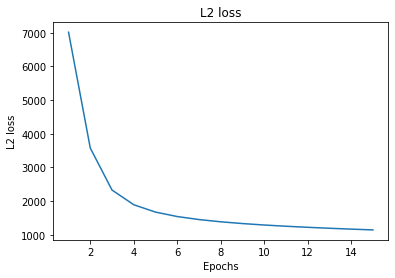

In [22]:
plt.plot(np.linspace(1, 15, 15), train_mse, label='Train')
plt.title('L2 loss')
plt.xlabel('Epochs')
plt.ylabel('L2 loss')
plt.show()

**Q3**  Train NeuralNet3 using Cross Entropy Loss and Adam Optimizer for 15 epochs. Experiment with different values of epochs, loss functions and optimizers.

*Read this [following article](https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c) to learn more about different optimizers*

## **Test**
The last step is to test the model we built and trained. The following code shows the testing process.

In [23]:
correct = 0
total = 0
with torch.no_grad():
    for itr, (image, label) in enumerate(testloader):
        image = image.view(image.shape[0], -1)
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        correct += predicted.eq(label.reshape(len(label),)).sum() 
        total += float(len(label))
    accuracy = correct / total
    print(f'Accuracy of Neural Network is {accuracy:.4f}')

Accuracy of Neural Network is 0.9196


**Q4** Report the accuracy of the model (NeuralNet3) that you just trained and tested above. Change the hyperparameters of the model to get an accuracy above 80%

In [24]:
#Report the accuracy in percentage eg 0.5713 is 57.13%
test_accuracy = 91.96

In [25]:
grader.grade(test_case_id = 'test_test_accuracy', answer = (test_accuracy))

Correct! You earned 2.0/2.0 points. You are a star!

Your submission has been successfully recorded in the gradebook.


After doing this worksheet, we hope you have a better understanding of Neural Networks and how to set them up!

## Submitting to the Autograder

First of all, please run your notebook from beginning to end and ensure you are getting all the points from the autograder!

Now go to the File menu and choose "Download .ipynb".  Go to [Gradescope](https://www.gradescope.com/courses/409970) and:

1. From "File" --> Download both .ipynb and .py files
1. Name these files `Neural_Networks_WS.ipynb` and `Neural_Networks_WS.py` respectively
1. Sign in using your Penn email address (if you are a SEAS student we recommend using the Google login) and ensure  your class is "CIS 5200"
1. Select **Worksheet: Neural_Networks**
1. Upload both files
1. PLEASE CHECK THE AUTOGRADER OUTPUT TO ENSURE YOUR SUBMISSION IS PROCESSED CORRECTLY!

You should be set! Note that this assignment has 10 autograded points that will show up upon submission. Points are awarded based on a combination of correctness and sufficient effort. 